
# A general guide to applying machine learning to computer architecture #
## Working code for the experiments and analysis ##

## Import Libraries ##

In [243]:
# utility libraries
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import random
import math

# preprocessing and fine tuning libraries
from sklearn.preprocessing import StandardScaler
# cross val
# grid search
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.base import clone
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

# Machine learning algorithms
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.cluster import KMeans


# Ensure output consistency of notebook
rnd_state = 42
np.random.seed(rnd_state)

In [230]:
# Names of features in the data
col_names = ['NS', 'IPC', 'BRhits', 'BRmiss', 'DRAMreq', 
             'DRAMrd', 'DRAMwr', 'DTLBacc', 'DTLBmiss', 'ITLBacc',
            'ITLBmiss', 'STLBacc', 'STLBmiss', 'DL1ld', 'DL1miss',
            'DL1st', 'IL1ld', 'IL1miss', 'IL1st', 'L2ld',
            'L2miss', 'L2st', 'L3ld', 'L3miss', 'L3st',
            'uopBR', 'uopFPaddsub', 'uopFPmuldiv', 'uopGeneric', 'uopLD',
            'uopST', 'uopTotal']

## Load Data ##

In [252]:
CUR_PATH = os.getcwd()

def combined_load_data(dir_list, path=CUR_PATH):
    path = path + '/' + dir_list
    all_files_df = []
    all_num_samples = []
    for filename in glob.glob(os.path.join(path, '*.stats')):
        df = pd.read_csv(filename, header=None, names=col_names, delim_whitespace=True)
        bmk_name = dir_list + '_' + filename.replace(path, '').replace('/pinned', '').replace('.stats', '')
        df['Bmk_Name'] = bmk_name
        # create target IPC of next quantum
        #target_IPC = df['IPC'].copy()
        #target_IPC = target_IPC.drop(0,0)
        #df = df.drop(len(df)-1,0)
        #df['target_IPC'] = target_IPC
        print(bmk_name , df.shape[0])
        all_num_samples.append(df.shape[0])
        all_files_df.append(df)
    print('Average num of samples per bmk:',sum(all_num_samples)//len(all_num_samples))
    print('Number of combined bmk files:', len(all_files_df), '\n')
    return all_files_df

def create_train_test_sets(file_df_list, test_ratio):#, rnd_seed = 42):
    n_test = math.floor(len(file_df_list)*test_ratio)
    # Shuffle the order of the data set
    #random.Random(rnd_seed).shuffle(file_df_list)
    random.shuffle(file_df_list)
    test_df_list = file_df_list[:n_test]
    train_df_list = file_df_list[n_test:]
    return train_df_list,test_df_list
                         
def combine_data_files_to_df(all_files, s ,verbose=True):
    frame = pd.DataFrame(pd.concat(all_files))
    # Remove useless instruction store feature
    #frame = frame.drop('IL1st',1)
    if verbose:
        print(s,'\nNumber of combined bmk files:', len(all_files))
        print('Shape:', frame.shape)
    return frame

In [232]:
# SPLIT TRAIN TEST SETS
data_dir = {'spec':'SPEC2006', 'splash':'SPLASH2'}

In [233]:
spec_data_list = combined_load_data(data_dir['spec'])
splash_data_list = combined_load_data(data_dir['splash'])

SPEC2006_libquantum 473
SPEC2006_gcc 193
SPEC2006_GemsFDTD 327
SPEC2006_cactusADM 146
SPEC2006_sjeng 196
SPEC2006_lbm 244
SPEC2006_gamess 107
SPEC2006_bzip2 202
SPEC2006_namd 91
SPEC2006_tonto 116
SPEC2006_perlbench 129
SPEC2006_bwaves 230
SPEC2006_mcf 287
SPEC2006_gobmk 239
SPEC2006_leslie3d 282
SPEC2006_xalancbmk 138
SPEC2006_milc 310
SPEC2006_h264ref 110
SPEC2006_zeusmp 117
SPEC2006_povray 170
SPEC2006_hmmer 91
SPEC2006_astar 261
SPEC2006_soplex 279
SPEC2006_gromacs 98
SPEC2006_omnetpp 347
SPEC2006_calculix 103
Average num of samples per bmk: 203
Number of combined bmk files: 26 

SPLASH2_lu.ncont 509
SPLASH2_fft 824
SPLASH2_ocean.cont 2826
SPLASH2_lu.cont 472
SPLASH2_cholesky 206
SPLASH2_water.sp 391
SPLASH2_barnes 1866
SPLASH2_radiosity 2633
SPLASH2_radix 155
SPLASH2_ocean.ncont 3122
SPLASH2_water.nsq 1422
SPLASH2_raytrace 944
SPLASH2_fmm 785
Average num of samples per bmk: 1242
Number of combined bmk files: 13 



In [235]:
# Make ratio based dataframe
def make_ratio_df(frame):
    epsilon = 0.003 # tot avoid dividing by zero
    ratio_frame = pd.DataFrame()

    ratio_frame['IPC'] = frame['IPC']
    ratio_frame['BR_miss'] = frame['BRmiss']/(frame['BRhits']+frame['BRmiss']+epsilon)

    #ratio_frame['DRAM_rd'] = frame['DRAMrd']/(frame['DRAMreq']+epsilon)

    #ratio_frame['DTLB_miss'] = frame['DTLBmiss']/(frame['DTLBacc']+epsilon)
    #ratio_frame['ITLB_miss'] = frame['ITLBmiss']/(frame['ITLBacc']+epsilon)
    #ratio_frame['STLB_miss'] = frame['STLBmiss']/(frame['STLBacc']+epsilon)

    ratio_frame['DL1_miss'] = frame['DL1miss']/(frame['DL1ld']+frame['DL1st']+epsilon)
    #ratio_frame['DL1_ld'] = frame['DL1ld']/(frame['DL1ld']+frame['DL1st']+epsilon)
    #ratio_frame['DL1_st_ratio'] = frame['DL1st_uopST']/(frame[DL1ld_uopLD]+frame[DL1st_uopST])

    ratio_frame['L2_miss'] = frame['L2miss']/(frame['L2ld']+frame['L2st']+epsilon)
    #ratio_frame['L2_ld'] = frame['L2ld']/(frame['L2ld']+frame['L2st']+epsilon)
    #ratio_frame['L2_st_ratio'] = frame['L2st']/(frame['L2ld']+frame['L2st'])

    ratio_frame['L3_miss'] = frame['L3miss']/(frame['L3ld']+frame['L3st']+epsilon)
    #ratio_frame['L3_ld'] = frame['L3ld']/(frame['L3ld']+frame['L3st']+epsilon)

    ratio_frame['uopBR'] = frame['uopBR']/(frame['uopTotal']+epsilon)
    #ratio_frame['uopFPaddsub'] = frame['uopFPaddsub']/(frame['uopTotal']+epsilon)
    #ratio_frame['uopFPmuldiv'] = frame['uopFPmuldiv']/(frame['uopTotal']+epsilon)
    ratio_frame['uopFP'] = (frame['uopFPmuldiv']+frame['uopFPaddsub'])/(frame['uopTotal']+epsilon)
    ratio_frame['uopGeneric'] = frame['uopGeneric']/(frame['uopTotal']+epsilon)
    ratio_frame['uopLD'] = frame['uopLD']/(frame['uopTotal']+epsilon)
    ratio_frame['uopST'] = frame['uopST']/(frame['uopTotal']+epsilon)
    return ratio_frame

def clean_data_col(df, col_name, thold):
    df = df[(df[col_name] > thold)]
    return df
    
# Normalize values
def normalize_df(train_df, test_df, verbose=False):
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(train_df.values)
    if verbose:
        print(scaler.mean_)
    rtn_train_df = pd.DataFrame(scaled_features, index=train_df.index, columns=train_df.columns)
    scaled_features_test = scaler.transform(test_df.values)
    rtn_test_df = pd.DataFrame(scaled_features_test, index=test_df.index, columns=test_df.columns)
    return rtn_train_df, rtn_test_df

def model_rmse_score(model,X,y,verbose=False):
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    rmse = np.sqrt(mse)
    if verbose:
        print('RMSE:', rmse)
    return rmse

In [284]:
def find_best_model(model_name, model, param_dist, X, y, n_iter_search = 10, cv=10, verbose=False):
    
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, cv=cv, 
                               n_iter=n_iter_search, scoring='neg_mean_squared_error', 
                               return_train_score=True)
    random_search.fit(X, y)
    print('\n', model_name,' - Best params:', random_search.best_params_)
    #print('Best estimator:', grid_search.best_estimator_)
    if verbose:
        print('Results for randomized gridsearch')
        cvres = random_search.cv_results_
        for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
            print(np.sqrt(-mean_score), params)
    return random_search.best_estimator_


def fine_tune_all_models(models_dict_list, X, y, n_iter_search = 10, cv=10, verbose=True):
    # plot validation curves
    #for model_name, model in zip(models_name_list, models_list, param_dist_list):
    tuned_models_list = []
    for model_dict in models_dict_list:
        tuned_model = find_best_model(model_dict['name'], model_dict['model'], model_dict['param_dist'], 
                                      X, y, n_iter_search, cv, verbose=False)
        tuned_models_list.append(tuned_model)
    return tuned_models_list
    
def print_data_set_bmk_names(l):    
    print('Num bmks:',len(l))
    for i in l:
        print(i['Bmk_Name'][0])
    print('\n\n')
    
def prepare_train_test_datasets(spec_df_list, splash_df_list, 
                               test_ratio = 0.3, verbose=True):
    #rnd_seed = randint(1, num_loops*10)
    # stratified split of bmk_df_list into train/test subsets
    spec_train_list, spec_test_list =  create_train_test_sets(spec_data_list, test_ratio)
    splash_train_list, splash_test_list =  create_train_test_sets(splash_data_list, test_ratio)
    if verbose:
        print('SPLASH-2 Train Benchmarks:', len(splash_train_list))
        print(splash_train_list)
        print('SPLASH-2 Test Benchmarks:', len(splash_test_list))
        print(splash_test_list)
        print('SPEC2006 Train Benchmarks:', len(spec_train_list))
        print(spec_train_list)
        print('SPEC2006 Test Benchmarks:', len(spec_test_list))
        print(spec_test_list)

    # Combine benchmark data sets
    train_df = combine_data_files_to_df(splash_train_list+spec_train_list, 'Train' , verbose=verbose)
    test_df = combine_data_files_to_df(splash_test_list+spec_test_list, 'Test' , verbose=verbose)

    # Clean data sets
    train_df = clean_data_col(train_df, 'IPC', 0.3)
    test_df = clean_data_col(test_df, 'IPC', 0.3)

    # Shuffle training and transform both data sets into ratio based attributes
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    train_df_ratio = make_ratio_df(train_df)
    test_df_ratio = make_ratio_df(test_df)

    # Prepare into X and target y
    y = train_df_ratio['IPC']
    X = train_df_ratio.drop('IPC',1)
    y_test = test_df_ratio['IPC']
    X_test = test_df_ratio.drop('IPC',1)

    # Normalize the data sets
    X, X_test =  normalize_df(X, X_test)

    return X, X_test, y, y_test
    
def run_multi_train_test_evals(spec_df_list, splash_df_list, models_name_list, tuned_models_list,
                               test_ratio = 0.3, num_loops = 1000, verbose=False):
    training_rmse_scores = {}
    testing_rmse_scores = {}
    for name in models_name_list:
        training_rmse_scores[name] = []
        testing_rmse_scores[name] = []
    # monte carlo loop
    for i in range(num_loops):
        # Get different data division
        X, X_test, y, y_test = prepare_train_test_datasets(spec_df_list, splash_df_list, 
                                                           test_ratio = test_ratio, verbose=verbose)
        # perform training and evaluation
        #it = 0
        for model_name, model in zip(models_name_list, tuned_models_list):
            #it += 1
            #print('iteration', it)
            model.fit(X,y)
            training_rmse_scores[model_name].append(model_rmse_score(model,X,y,verbose=False))
            testing_rmse_scores[model_name].append(model_rmse_score(model,X_test,y_test,verbose=False))

    # return the errors for both
    return training_rmse_scores, testing_rmse_scores
  

In [258]:
models_dict_list = []
sgd_lin = {'name': 'SGD linear regression',
           'model': SGDRegressor(penalty='elasticnet', random_state=rnd_state),
           'param_dist': {
               "l1_ratio": [0, 0.2, 0.4, 0.6, 0.8, 1]}
        }
models_dict_list.append(sgd_lin)

dtree = {'name': 'decision tree',
         'model': DecisionTreeRegressor(random_state=rnd_state),
         'param_dist': {
             "max_depth": [3, None],
             "max_features": range(1, 6), #list(range(2,30)) 
             "min_samples_split": range(2, 6),
             "min_samples_leaf": range(1, 3)}
        }
models_dict_list.append(dtree)

rforest = {'name': 'random forest',
           'model': RandomForestRegressor(random_state=rnd_state),
           'param_dist': {
               "max_depth": [3, None],
               "max_features": range(1, 6),
               "n_estimators": range(3, 30),
               "bootstrap": [True, False]}
          }
models_dict_list.append(rforest)

ann = {'name': 'ann',
       'model': MLPRegressor(random_state=rnd_state),
       'param_dist': {
           'hidden_layer_sizes': [(2,), (6,), (25,), (100,), (6,6), (25,5), (10,10)],
           'max_iter': [200, 400],
           'early_stopping' : [False, True]}
      }
models_dict_list.append(ann)


knn = {'name': 'knn',
       'model': KNeighborsRegressor(),
       'param_dist': {
           'n_neighbors':range(2,30),
           'weights': ['uniform', 'distance']}
      }
models_dict_list.append(knn)


In [254]:
X, X_test, y, y_test = prepare_train_test_datasets(spec_data_list, splash_data_list)

Train 
Number of combined bmk files: 29
Shape: (17041, 33)
Test 
Number of combined bmk files: 10
Shape: (4400, 33)


In [259]:
tuned_models_list = fine_tune_all_models(models_dict_list, X, y, n_iter_search = 6, cv=10, verbose=True)


 SGD linear regression  - Best params: {'l1_ratio': 1}

 decision tree  - Best params: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 3, 'max_depth': None}

 random forest  - Best params: {'n_estimators': 20, 'max_features': 3, 'max_depth': None, 'bootstrap': True}

 ann  - Best params: {'max_iter': 400, 'hidden_layer_sizes': (100,), 'early_stopping': False}

 knn  - Best params: {'weights': 'distance', 'n_neighbors': 5}


In [291]:
tuned_models_list

[SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
        fit_intercept=True, l1_ratio=1, learning_rate='invscaling',
        loss='squared_loss', n_iter=5, penalty='elasticnet', power_t=0.25,
        random_state=42, shuffle=True, verbose=0, warm_start=False),
 DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=3,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features=3, max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
 MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
        be

In [288]:
models_name_list = []
for i in models_dict_list:
    models_name_list.append(i['name'])
    
training_rmse_scores, testing_rmse_scores = run_multi_train_test_evals(spec_data_list, splash_data_list, models_name_list, tuned_models_list,
                               test_ratio = 0.3, num_loops = 1000, verbose=False)

In [290]:
#1000 iterations
for i in models_name_list:
    print(i)
    print('Training Error:', np.mean(training_rmse_scores[i]), 'stdev:', np.std(training_rmse_scores[i]))
    print('Testing Error:', np.mean(testing_rmse_scores[i]), 'stdev:', np.std(testing_rmse_scores[i]))

SGD linear regression
Training Error: 0.3954299301480203 stdev: 0.0386838700258497
Testing Error: 0.5247613729721706 stdev: 0.1405085508775828
decision tree
Training Error: 0.025520663403762755 stdev: 0.002671145526542709
Testing Error: 0.6310401302781422 stdev: 0.19093286936506654
random forest
Training Error: 0.018771621788556656 stdev: 0.0013832632345796994
Testing Error: 0.4981054691147754 stdev: 0.1567415448971619
ann
Training Error: 0.0738349971039843 stdev: 0.004708750109827736
Testing Error: 0.5839497637354271 stdev: 0.21269865765000512
knn
Training Error: 5.891404183178998e-06 stdev: 3.3886039935323666e-06
Testing Error: 0.551616771624821 stdev: 0.15714713516210993


In [287]:
#100 iterations
for i in models_name_list:
    print(i)
    print('Training Error:', np.mean(training_rmse_scores[i]), 'stdev:', np.std(training_rmse_scores[i]))
    print('Testing Error:', np.mean(testing_rmse_scores[i]), 'stdev:', np.std(testing_rmse_scores[i]))

SGD linear regression
Training Error: 0.4008874834209037 stdev: 0.03312397566659642
Testing Error: 0.5080173152551942 stdev: 0.11394730922596616
decision tree
Training Error: 0.025444559383289076 stdev: 0.0023632849738738624
Testing Error: 0.6082597826562686 stdev: 0.1879368741466826
random forest
Training Error: 0.019047680221397488 stdev: 0.0013609100997354598
Testing Error: 0.46456351177571414 stdev: 0.13576597975391458
ann
Training Error: 0.07388696464651642 stdev: 0.004239287652139079
Testing Error: 0.5399504756686833 stdev: 0.2015594145722837
knn
Training Error: 6.079762227935864e-06 stdev: 3.3382538012723693e-06
Testing Error: 0.5196263811761519 stdev: 0.14788215995409965


## Explore the Data ##

In [294]:
train_df = combine_data_files_to_df(splash_train_list+spec_train_list, s='train')
test_df = combine_data_files_to_df(splash_test_list+spec_test_list, s='test')
train_df = train_df[(train_df['IPC'] > 0.3)]
test_df = test_df[(test_df['IPC'] > 0.3)]
train_df_ratio = make_ratio_df(train_df)
test_df_ratio = make_ratio_df(test_df)

train 
Number of combined bmk files: 29
Shape: (12779, 33)
test 
Number of combined bmk files: 10
Shape: (8662, 33)


In [295]:
# Define useful functions

# Explore individual correlations
def explore_indv_corr(df,focus_cols=['IPC']):
    idv_corrs = df.corr().filter(focus_cols).drop(focus_cols).sort_values(by=['IPC'],ascending=False)
    print('One to One Correlations')
    #print(idv_corrs)
    return idv_corrs

# Explore feature correlation heatmap
def corr_heatmap(df, save_name = 'min_corr_heatmap.png'):
    plt.figure(figsize = (10,7))
    corr = df.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, annot=True, mask=mask, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)
    plt.savefig(save_name)
    plt.show()
    
# Find redundant features
# Taken from arun's answer in: https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    #print(len(labels_to_drop))
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    print("Top Absolute Correlations")
    print(au_corr[0:n])
    return au_corr[0:n]


*** Reduce data set to set of attributes within scope of work ***

In [296]:
explore_indv_corr(train_df_ratio)

One to One Correlations


,IPC
uopFP,0.115692
uopST,0.017567
uopBR,-0.007666
uopGeneric,-0.070015
uopLD,-0.153774
BR_miss,-0.239916
DL1_miss,-0.459863
L2_miss,-0.517187
L3_miss,-0.552708


In [297]:
print(train_df_ratio.shape)

(12548, 10)


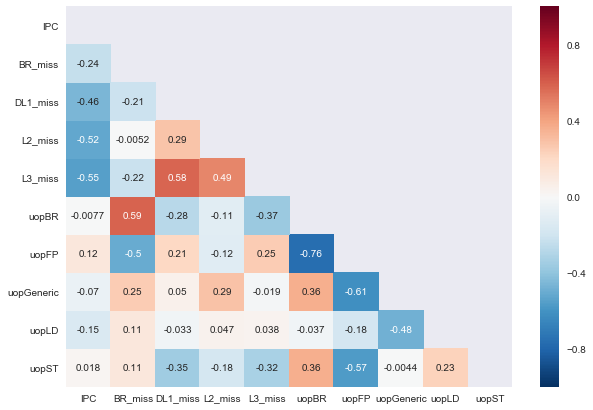

In [180]:
corr_heatmap(train_df_ratio)

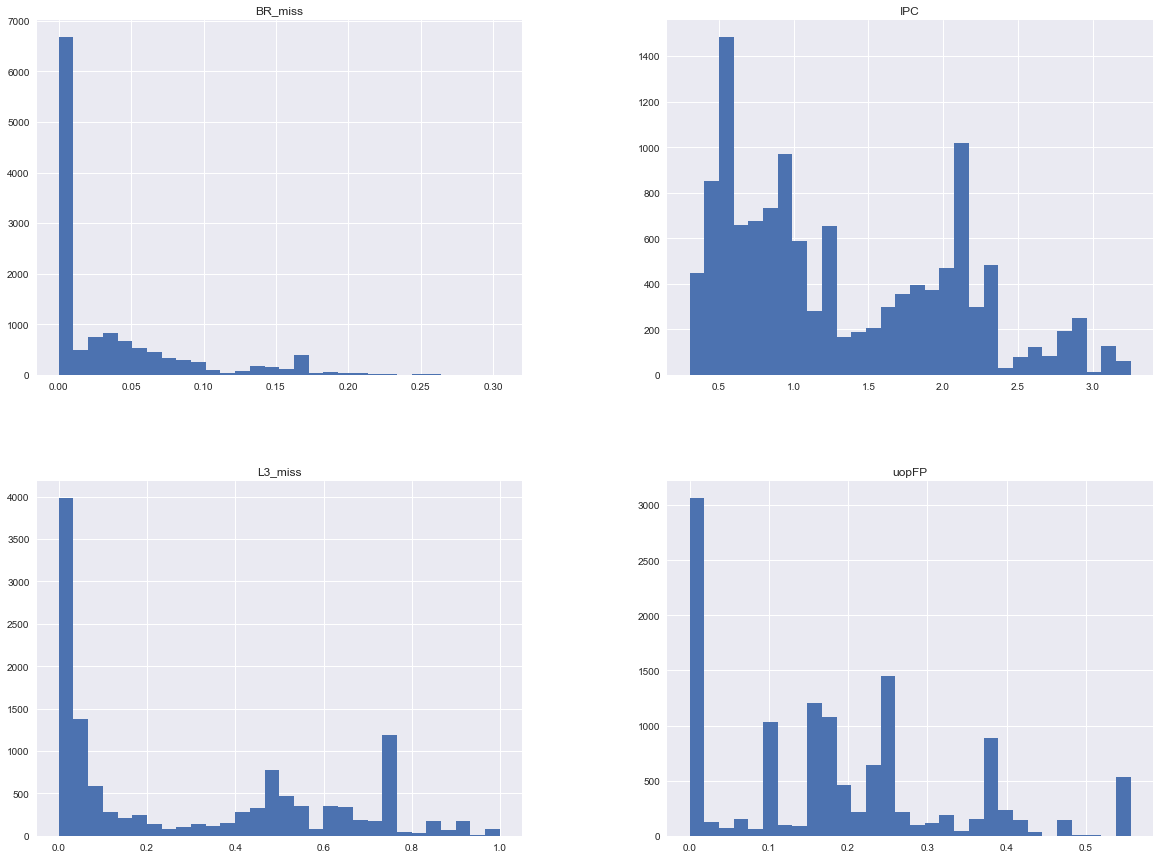

In [208]:
col_of_interest = ['IPC', 'L3_miss', 'BR_miss', 'uopFP']
# 'uopBR', 'uopFPaddsub', 'uopFPmuldiv', 'uopGeneric', 'uopLD',
#            'uopST', 'uopTotal']
train_df_ratio[col_of_interest].hist(bins=30, figsize=(20,15))
#save_fig("attribute_histogram_plots")
plt.savefig('min_stat_histograms.png')
plt.show()

In [298]:
# Compare shapes of unfiltered df, filtered df, and ratio df 
print('Train X shape:', X.shape)
print('Train y shape:', y.shape)

print('Test X shape:', X_test.shape)
print('Test y shape:', y_test.shape)

Train X shape: (16710, 9)
Train y shape: (16710,)
Test X shape: (4387, 9)
Test y shape: (4387,)


In [21]:
# Examine y targets
#print('IPC samples:')
#print(y)

In [299]:
# Check is any values are missing
print(X.isnull().values.any())
print(X_test.isnull().values.any())

False
False


## Machine learning models ##

In [224]:
# Useful functions
def lin_ref_func(X,y):
    lin_reg = LinearRegression()
    lin_reg.fit(X, y)
    #model_rmse_score(lin_reg,X,y)
    return lin_reg
    
def model_rmse_score(model,X,y):
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    rmse = np.sqrt(mse)
    print('RMSE:', rmse)
    return rmse

def all_indv_lin_reg_scores(X,y,X_test,y_test):
    '''runs linear regression on all attributes one by one 
    independently vs IPC nand outputs their RMSE score on 
    the train and test sets'''
    indv_rmse_train_scores = []
    indv_rmse_test_scores = []
    for attr_name in X:
        print('Attribute:',attr_name)
        x_indv = X.as_matrix(columns=[attr_name])
        x_test_indv = X_test.as_matrix(columns=[attr_name])
        #indv_lin_reg = lin_ref_func(x_indv,y)
        indv_lin_reg = LinearRegression()
        indv_lin_reg.fit(x_indv, y)
        print('Train RMSE')
        indv_rmse_train_scores.append(model_rmse_score(indv_lin_reg,x_indv,y))
        print('Test RMSE')
        indv_rmse_test_scores.append(model_rmse_score(indv_lin_reg,x_test_indv,y_test))
        # Plot outputs
        y_test_pred = indv_lin_reg.predict(x_test_indv)
        y_pred = indv_lin_reg.predict(x_indv)
        plt.figure(figsize = (10,7))
        #plt.scatter(x_test_indv, y_test, marker='o', color='red')
        plt.scatter(x_indv, y, marker='x', color='green')
        plt.plot(x_indv, y_pred, color='blue', linewidth=3)
        #plt.plot(x_test_indv, y_test_pred, color='blue', linewidth=3)
        plt.title('Linear regression - ' + attr_name + ' vs IPC')
        plt.xlabel('Attribute value')
        plt.ylabel('IPC')
        plt.legend(['Prediction line','Train instance'])
        #plt.legend(['Prediction line', 'Test instance','Train instance'])
        #plt.xticks(ind, list(X.columns))
        plt.xticks(())
        plt.yticks(())
        plt.savefig(attr_name+'_lin_reg_plot.png')
        plt.show()

    ind = np.arange(len(X.columns))
    plt.figure(figsize = (10,7))
    plt.ylabel('RMSE')
    plt.title('Linear regression of individual attributes')
    plt.xticks(ind, list(X.columns),rotation='vertical')
    plt.plot(ind,indv_rmse_train_scores, 'g^')
    plt.plot(ind,indv_rmse_test_scores, 'bs')
    plt.legend(['Train', 'Test'])
    plt.savefig('ALL_lin_reg_plot.png')
    plt.show()


def show_train_test_rmse_scores(model, X, y, X_test, y_test, data_dir, name):
    print('\nMODEL:', name)
    print('\nTRAIN RESULTS:')
    model_rmse_score(model,X,y)
    print('\nVALIDATION RESULTS:')
    print(np.mean(np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5))))
    print('\nTEST RESULTS:')
    model_rmse_score(model,X_test,y_test)
    print('\n')
    
def full_train_test_fit_score(model, param_grid, X, X_test, y, y_test, data_dir, name, verbose=False):
    model_opt = find_best_model(model, param_grid, X, y, verbose=verbose)
    show_train_test_rmse_scores(model_opt, X, y, X_test, y_test, data_dir, name)
    return model_opt

def plot_feature_importances(clf,df,save_name = 'feature_importance.png'):
    features = df.columns
    importances = clf.feature_importances_
    indices = np.argsort(importances)
    plt.figure(figsize = (10,7))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('Relative Importance')
    plt.savefig(save_name)
    plt.show()
    
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5),
                        save_name = 'learning_curve.png'):
    # Taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
   
    plt.figure(figsize = (10,7))
    #plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("RMSE")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=n_jobs, train_sizes=train_sizes)
    # RMSE scores
    #train_scores_mean = np.sqrt(-np.mean(train_scores, axis=1))
    #train_scores_std = np.std(train_scores, axis=1)
    #test_scores_mean = np.sqrt(-np.mean(test_scores, axis=1))
    #test_scores_std = np.std(test_scores, axis=1)
    train_scores_mean = np.mean(np.sqrt(-train_scores), axis=1)
    train_scores_std = np.std(np.sqrt(-train_scores), axis=1)
    test_scores_mean = np.mean(np.sqrt(-test_scores), axis=1)
    test_scores_std = np.std(np.sqrt(-test_scores), axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.savefig(save_name)
    plt.show()
    return plt


def plot_validation_curve(estimator, title, X, y, param_name, param_range, ylim=None, cv=5,
                         save_name='validation_curve.png', is_ann=False):
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring='neg_mean_squared_error', n_jobs=1)
    train_scores_mean = np.mean(np.sqrt(-train_scores), axis=1)
    train_scores_std = np.std(np.sqrt(-train_scores), axis=1)
    test_scores_mean = np.mean(np.sqrt(-test_scores), axis=1)
    test_scores_std = np.std(np.sqrt(-test_scores), axis=1)

    plt.figure(figsize = (10,7))
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("RMSE")
    if ylim is not None:
        plt.ylim(*ylim)
    plt.grid()
    if is_ann:
        #usually an ANN
        param_range = range(len(param_range))
        my_xticks = ['(2,)', '(6,)', '(25,)', '(2,2)', '(6,6)', '(25,5)', '(10,10)']
        plt.xticks(param_range, my_xticks)
    
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="darkorange")
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="navy")
    #plt.xscale('linear')
    #plt.xticks(np.arange(len(param_range)), param_range)
    plt.legend(loc="best")
    plt.savefig(save_name)
    plt.show()
    return plt



### Linear Regression ###

Attribute: BR_miss
Train RMSE
RMSE: 0.7284320529183839
Test RMSE
RMSE: 0.5497175253805786


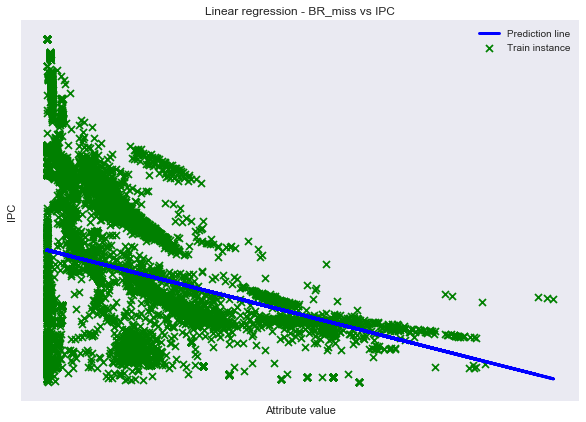

Attribute: DL1_miss
Train RMSE
RMSE: 0.6663006027209659
Test RMSE
RMSE: 0.581443101761908


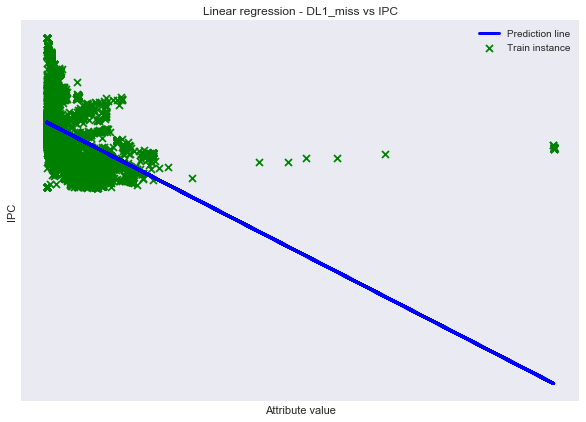

Attribute: L2_miss
Train RMSE
RMSE: 0.6422015082563135
Test RMSE
RMSE: 0.6582828188544078


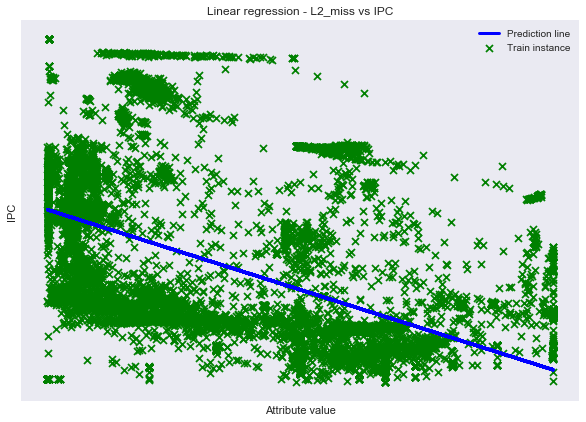

Attribute: L3_miss
Train RMSE
RMSE: 0.6253202120603105
Test RMSE
RMSE: 0.6246141339638469


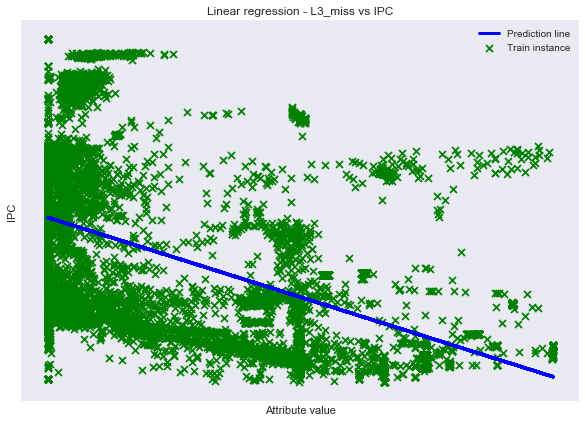

Attribute: uopBR
Train RMSE
RMSE: 0.7503249607682595
Test RMSE
RMSE: 0.5517896263054706


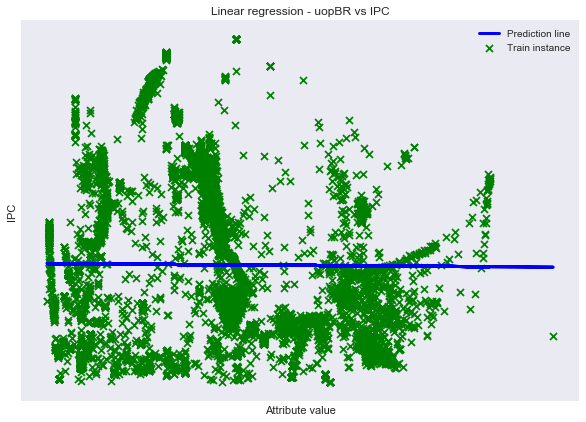

Attribute: uopFP
Train RMSE
RMSE: 0.7453085459791918
Test RMSE
RMSE: 0.5733467217054025


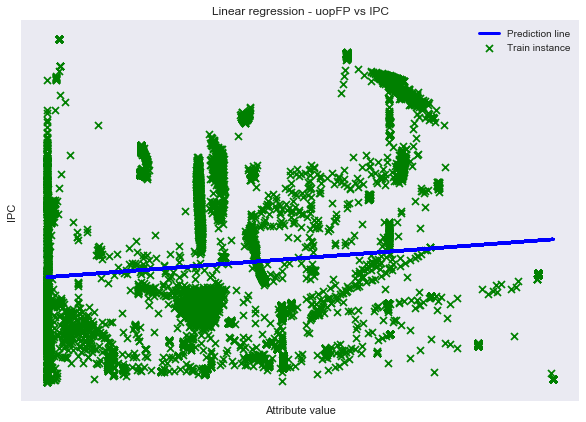

Attribute: uopGeneric
Train RMSE
RMSE: 0.7485056137043884
Test RMSE
RMSE: 0.595752658835821


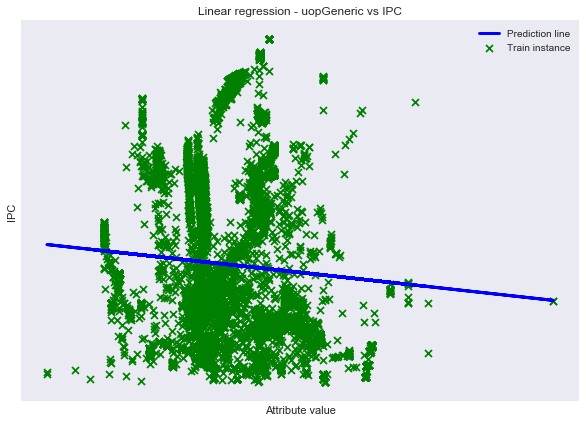

Attribute: uopLD
Train RMSE
RMSE: 0.7414224315706278
Test RMSE
RMSE: 0.4925254159564689


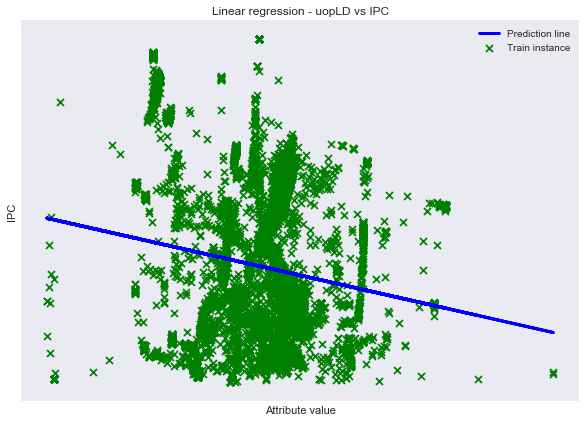

Attribute: uopST
Train RMSE
RMSE: 0.7502312208745278
Test RMSE
RMSE: 0.5593299464772863


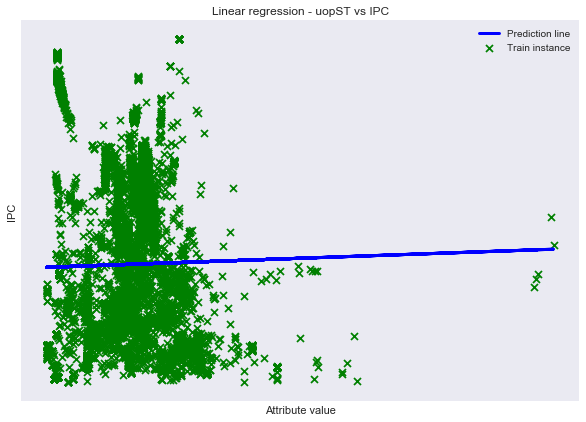

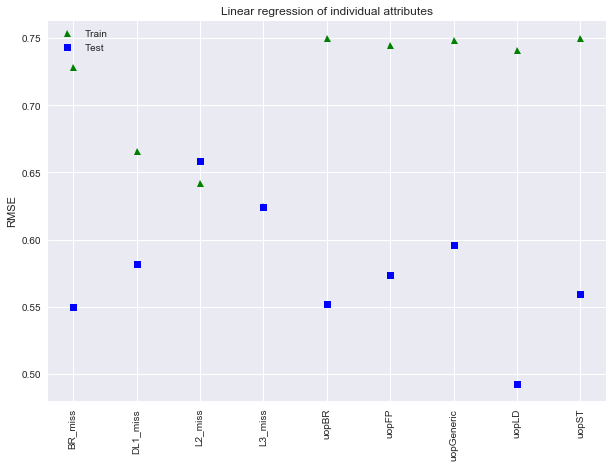

In [193]:
all_indv_lin_reg_scores(X,y,X_test,y_test)


In [195]:
def get_specific_lin_model_result(X, y, X_test, y_test, lin_attr_name = 'uopLD'):
    x_indv = X.as_matrix(columns=[lin_attr_name])
    x_test_indv = X_test.as_matrix(columns=[lin_attr_name])
    indv_lin_reg = LinearRegression()
    indv_lin_reg.fit(x_indv, y)
    print('Train RMSE')
    model_rmse_score(indv_lin_reg,x_indv,y)
    print('Test RMSE')
    model_rmse_score(indv_lin_reg,x_test_indv,y_test)
    print('LinReg Model coefficient:', indv_lin_reg.coef_, 'intercept:', indv_lin_reg.intercept_)
get_specific_lin_model_result(X, y, X_test, y_test)

Train RMSE
RMSE: 0.7414224315706278
Test RMSE
RMSE: 0.4925254159564689
LinReg Model coefficient: [-0.11538376] intercept: 1.314439432578897


In [219]:
lin_reg = lin_ref_func(X,y)
show_train_test_rmse_scores(lin_reg, X, y, X_test, y_test, data_dir, 'MLinear Regression')


MODEL: MLinear Regression

TRAIN RESULTS:
RMSE: 0.4714178534438799

VALIDATION RESULTS:
0.47187086043842835

TEST RESULTS:
RMSE: 0.3628228568445315




### Stochastic Gradient Descent Regression ###

In [220]:
#sgd_param_grid = [ #4x6x3 = 72 models
#    {'loss': ['squared_loss', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
#    'l1_ratio': [ 1], 'eta0': [0.001, 0.01]}
#  ]
sgd_param_grid = [ #4x6x3 = 72 models
    {'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'l1_ratio': [0, 0.5, 1], 'eta0': [0.001, 0.01, 0.1]}
  ]

sgd_opt = full_train_test_fit_score(SGDRegressor(n_iter=1000, penalty='elasticnet', random_state=rnd_state), 
                                                   sgd_param_grid, X, X_test, y, y_test,
                                                   data_dir, 'SGD Regression', verbose=False)



Best params: {'eta0': 0.01, 'l1_ratio': 0.5, 'loss': 'squared_loss'}

MODEL: SGD Regression

TRAIN RESULTS:
RMSE: 0.4723281812038919

VALIDATION RESULTS:
0.4724671197153909

TEST RESULTS:
RMSE: 0.3664287718114051




In [202]:
print(np.mean(np.sqrt(-cross_val_score(sgd_opt, X, y, scoring='neg_mean_squared_error', cv=5))))

0.1558905836755195


/Users/dnemi/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:811: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


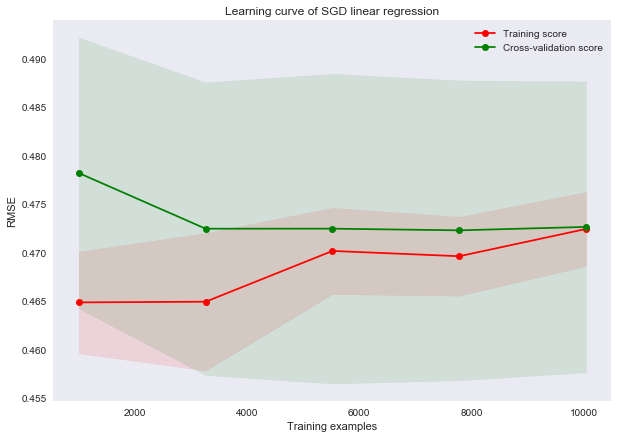

<module 'matplotlib.pyplot' from '/Users/dnemi/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [221]:
plot_learning_curve(sgd_opt, 'Learning curve of SGD linear regression', X, y,
                    save_name='sgd_learning_curve.png')


### Decision Tree Regression ###

In [198]:
tree_param_grid = [{'max_depth': range(2,30), 'min_samples_split': [2, 4, 6], 
                    'min_samples_leaf': [1, 2, 4, 6]}]


tree_opt = full_train_test_fit_score(DecisionTreeRegressor(random_state=rnd_state), 
                                                   tree_param_grid, X, X_test, y, y_test,
                                                   data_dir, 'Decision Tree Regression', verbose=False)



Best params: {'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 2}

MODEL: Decision Tree Regression

TRAIN RESULTS:
RMSE: 0.0009610793351791263

VALIDATION RESULTS:
0.07490407791990225

TEST RESULTS:
RMSE: 0.2627976629477391




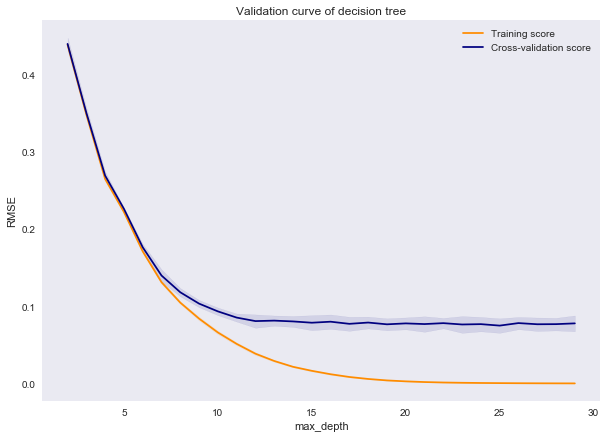

<module 'matplotlib.pyplot' from '/Users/dnemi/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [197]:
plot_validation_curve(DecisionTreeRegressor(random_state=rnd_state, min_samples_leaf = 1, min_samples_split= 2), 
                      'Validation curve of decision tree', 
                      X, y, 
                      'max_depth', 
                      param_range = list(range(2,30)),#[2, 3, 4, 5, 8, 10, 20, 30, 50],
                     save_name='min_dtree_validation_curve.png')

/Users/dnemi/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:811: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


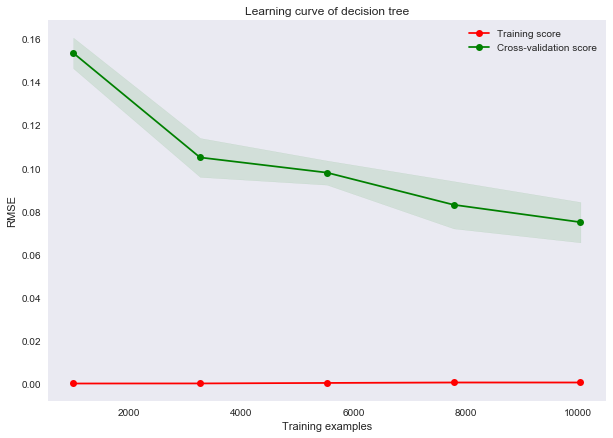

<module 'matplotlib.pyplot' from '/Users/dnemi/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [199]:
plot_learning_curve(tree_opt, 'Learning curve of decision tree', X, y,
                    save_name='min_dtree_learning_curve.png')

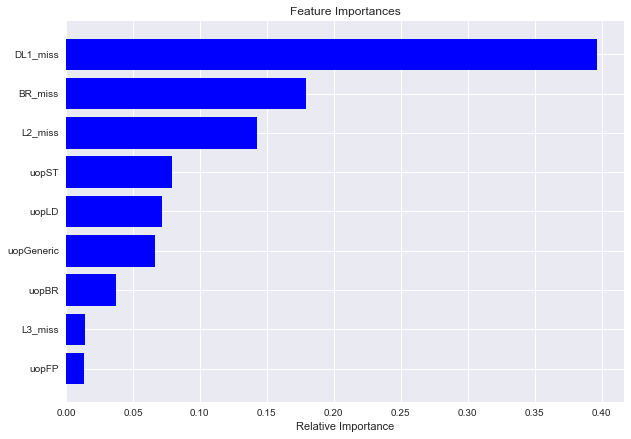

In [200]:
plot_feature_importances(tree_opt,X,save_name='min_dtree_feature_importances.png')


### Random Forest Regressor ###

In [214]:
forest_param_grid = [{
    # try 20 (4×5) combinations of hyperparameters
    'n_estimators': [3, 10, 20, 30], 'max_features': [ 2, 4, 6], 'max_depth': range(2,30)}
    # then try 6 (2×3) combinations with bootstrap set as False
    #{'bootstrap': [False], 'n_estimators': [3, 10, 20, 30], 'max_features': [2, 4, 6]},
  ]

forest_opt = full_train_test_fit_score(RandomForestRegressor(random_state=rnd_state), 
                                                   forest_param_grid, X, X_test, y, y_test,
                                                   data_dir, 'Random Forest Regression', verbose=False)



Best params: {'max_depth': 25, 'max_features': 4, 'n_estimators': 30}

MODEL: Random Forest Regression

TRAIN RESULTS:
RMSE: 0.019596864515479713

VALIDATION RESULTS:
0.04917516862972469

TEST RESULTS:
RMSE: 0.3952011041266514




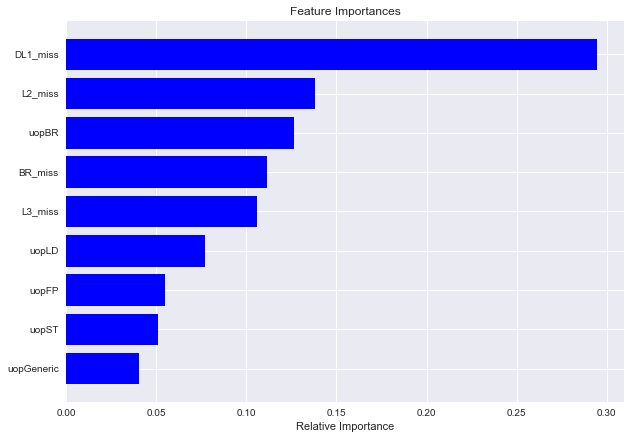

In [215]:
plot_feature_importances(forest_opt,X,save_name='min_rforest_feature_importances.png')

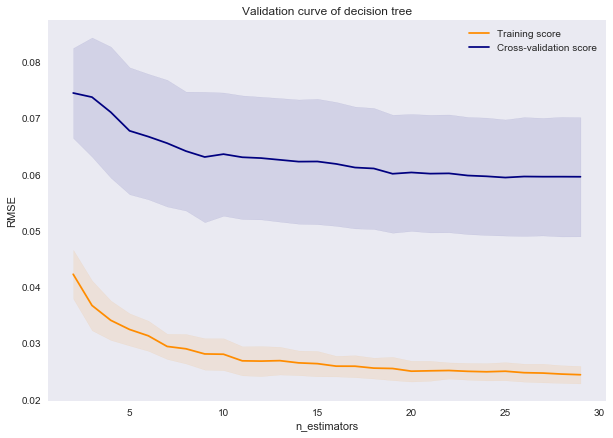

<module 'matplotlib.pyplot' from '/Users/dnemi/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [203]:
plot_validation_curve(RandomForestRegressor(random_state=rnd_state), 
                      'Validation curve of decision tree', 
                      X, y, 
                      'n_estimators', 
                      param_range = list(range(2,30)),#[2, 3, 4, 5, 8, 10, 20, 30, 50],
                     save_name='min_rforest_validation_curve.png')

/Users/dnemi/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:811: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


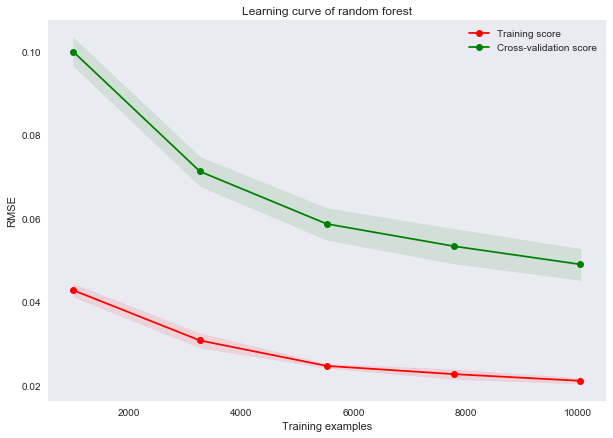

<module 'matplotlib.pyplot' from '/Users/dnemi/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [216]:
plot_learning_curve(forest_opt, 'Learning curve of random forest', X, y,
                    save_name='min_rforest_learning_curve.png')

### Support Vector Regression ###

In [ ]:
svr_param_grid = [
    #{'kernel':('linear', 'rbf'), 'C':[1, 5, 10], 'epsilon': [0.03, 0.1, 0.2]}
    {'kernel':('linear', 'rbf'), 'C':[1], 'epsilon': [0.1]}
  ]

svr_opt, svr_opt_ratio = full_train_test_fit_score(SVR(), 
                                                   svr_param_grid, X, X_test, y, y_test,
                                                   data_dir, 'Support Vector Regressor', verbose=False)

### Neural Network: Multilayer Perceptron Regression ###

In [225]:
mlp_param_grid = [
    {#'hidden_layer_sizes':[(6,6)], 
     'hidden_layer_sizes':[(2,), (6,), (25,), (2,2), (6,6), (25,5), (10,10)],
     'activation':['relu'],
     'max_iter': [200, 400],
     'early_stopping' : [False, True],
    'alpha': [0.01, 0.1]}
  ]

mlp_opt = full_train_test_fit_score(MLPRegressor(random_state = rnd_state), 
                                                   mlp_param_grid, X, X_test, y, y_test,
                                                   data_dir, 'MLP Regressor', verbose=False)

/Users/dnemi/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)



Best params: {'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (25, 5), 'max_iter': 200}

MODEL: MLP Regressor

TRAIN RESULTS:
RMSE: 0.08689061383016153

VALIDATION RESULTS:
0.10215671567060522

TEST RESULTS:
RMSE: 0.5381490472289676




/Users/dnemi/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


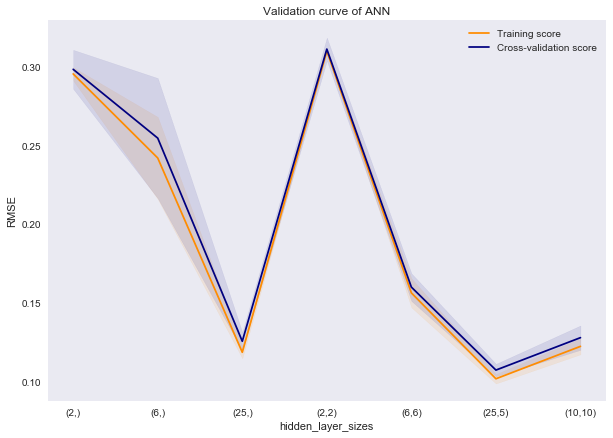

<module 'matplotlib.pyplot' from '/Users/dnemi/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [228]:
plot_validation_curve(MLPRegressor(random_state = rnd_state), 
                      'Validation curve of ANN', 
                      X, y, 
                      'hidden_layer_sizes', 
                      param_range = [(2,), (6,), (25,), (2,2), (6,6), (25,5), (10,10)],
                     save_name='ann_validation_curve_min.png', is_ann=True)

/Users/dnemi/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:811: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):
/Users/dnemi/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Users/dnemi/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Users/dnemi/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimiza

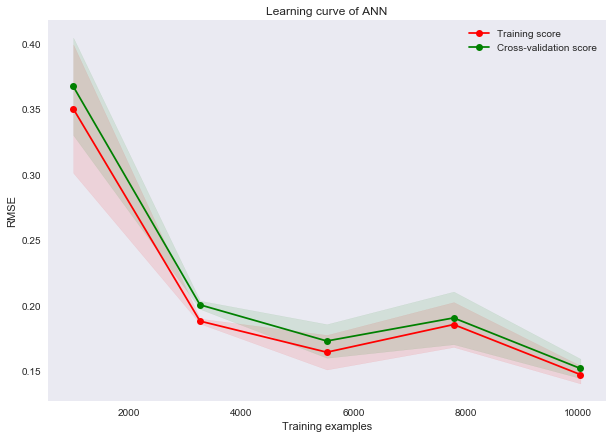

<module 'matplotlib.pyplot' from '/Users/dnemi/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [223]:
plot_learning_curve(mlp_opt, 'Learning curve of ANN', X, y,
                    save_name='ann_learning_curve.png')

### K Nearest Neighbors Predictor ###

In [211]:
knn_param_grid = [
    {'n_neighbors':range(2,30),
    'weights': ['uniform', 'distance']}
  ]

knn_opt = full_train_test_fit_score(KNeighborsRegressor(),
                                    knn_param_grid, X, X_test, y, y_test,
                                    data_dir, 'K Nearest Neighbors Regressor', verbose=False)



Best params: {'n_neighbors': 3, 'weights': 'distance'}

MODEL: K Nearest Neighbors Regressor

TRAIN RESULTS:
RMSE: 1.4016448079626326e-18

VALIDATION RESULTS:
0.05192414321286687

TEST RESULTS:
RMSE: 0.47473862849745996




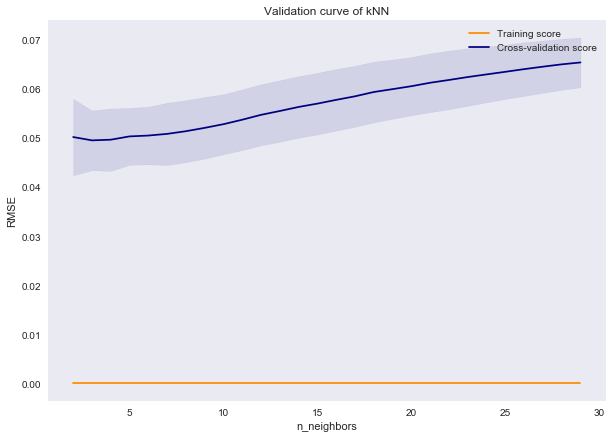

<module 'matplotlib.pyplot' from '/Users/dnemi/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [292]:
plot_validation_curve(KNeighborsRegressor(weights= 'distance'), 'Validation curve of kNN', 
                      X, y, 
                      'n_neighbors', 
                      param_range = range(2,30),
                     save_name='final_knn_validation_curve.png')